In [3]:
#%pip install datasets

In [4]:
import pandas as pd
from datasets import Dataset, DatasetDict
from sklearn.preprocessing import LabelEncoder

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
cd drive/MyDrive/"Colab Notebooks"

/content/drive/MyDrive/Colab Notebooks


In [7]:
ls

bert_base_uncased/              download_bert_model.ipynb  gpt2-xl.ipynb  twitter-emotion/
bert-text-classification.ipynb  gpt2-xl/                   ibm-ml/        using_custom_model.ipynb


In [8]:
df = pd.read_csv('twitter-emotion/twitter_training.csv')
df.columns = ['id','area','label','text']
df = df[['text','label']]
df = df.dropna()
df = df.reset_index(drop=True)
df = df.head(100)
df['text'] = df['text'].apply(lambda x: str(x).lower())
df.head()

,text,label
0,i am coming to the borders and i will kill you...,Positive
1,im getting on borderlands and i will kill you ...,Positive
2,im coming on borderlands and i will murder you...,Positive
3,im getting on borderlands 2 and i will murder ...,Positive
4,im getting into borderlands and i can murder y...,Positive


In [9]:
class_labels = df.label.values
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(class_labels)
df['label'] = encoded_labels
df.head()

,text,label
0,i am coming to the borders and i will kill you...,2
1,im getting on borderlands and i will kill you ...,2
2,im coming on borderlands and i will murder you...,2
3,im getting on borderlands 2 and i will murder ...,2
4,im getting into borderlands and i can murder y...,2


In [10]:
class_ct = len(df.label.unique())
print('Number Of Classes:', class_ct)

Number Of Classes: 3


In [11]:
from sklearn.model_selection import train_test_split

X = df [['text']]
y = df ['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

# BERT Training

In [12]:
import pickle
from torch import optim
import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import AutoTokenizer, AutoModel

In [13]:
pickle_filename = 'bert_base_uncased/BertForSequenceClassification_bert_base_uncased.pkl'

with open(pickle_filename, 'rb') as file:
  loaded_object = pickle.load(file)

tokenizer = loaded_object['tokenizer']
model = loaded_object['model']

In [14]:
from transformers import BertForSequenceClassification, BertConfig
import torch.nn as nn

num_labels = class_ct
in_features = model.classifier.in_features
model.classifier = nn.Linear(in_features, num_labels)

# Update the model configuration
model.config.num_labels = num_labels

In [15]:
model.classifier

Linear(in_features=768, out_features=3, bias=True)

In [16]:
import re

# Update tokenizer vocabulary
def get_unique_words(string):
  pattern = r'\d+'
  string = re.sub(pattern, '', string)

  words = str(string).split()
  unique_words = set()

  for word in words:
    unique_words.add(word)
  unique_words_list = list(unique_words)

  return unique_words_list

In [17]:
my_vocab = get_unique_words(''.join(df.text))
print(my_vocab[:5])

tokenizer.add_tokens(my_vocab)
model.resize_token_embeddings(len(tokenizer))

['real', 'drops.', 'events', 'wait', 'pretty']


Embedding(30735, 768)

In [18]:
'msft' in tokenizer.get_vocab()

False

In [19]:
# Create an instance of the dataset

texts = X_train['text'].tolist()
labels = y_train.tolist()

your_train_data = []

for text, label in zip(texts, labels):
  example = {
      'text': text,
      'label': label
      }
  your_train_data.append(example)

your_train_data[:3]

[{'text': "grosskreutz looked pretty cool, even despite the unfunny spelling, until it turned into another survival game. i really can't wait for this crap trend to die",
  'label': 0},
 {'text': ' . . [  ', 'label': 1},
 {'text': '.. 45', 'label': 1}]

In [20]:
# Create an instance of the dataset

texts = X_val['text'].tolist()
labels = y_val.tolist()

your_val_data = []

for text, label in zip(texts, labels):
  example = {
      'text': text,
      'label': label
      }
  your_val_data.append(example)

your_val_data[:3]

[{'text': 'i am coming to the borders and i will kill you all,', 'label': 2},
 {'text': "going to finish up borderlands 2 today. i've got some new events set up and am look forward to a good stream! starting in about 20 hour!",
  'label': 2},
 {'text': 'grounded almost looked pretty cool even despite the borderlands tier unfunny writing until it became yet another survival crafting game. i really can’t wait for this shitty trend to die',
  'label': 0}]

In [21]:
from transformers import BertForSequenceClassification, BertTokenizer
import torch
from torch.utils.data import DataLoader

# Create a DataLoader
batch_size = 32
train_loader = DataLoader(your_train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(your_val_data, batch_size=batch_size, shuffle=True)

In [22]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [23]:
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertForSequenceClassification

# Define the optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()

loss_history = []
accuracy_history = []

# Training Loop
model.to(device)
model.train()

num_epochs = 2
for epoch in range(num_epochs):
  print('EPOCH STATUS:', str(epoch+1), '/', num_epochs)
  for batch in tqdm(train_loader):
    #Unpack the inputs and Labels
    input_texts, labels = batch['text'], batch['label']

    #Convert input_texts to input_ids and attention_mask
    inputs = tokenizer.batch_encode_plus(
        input_texts,
        padding=True,
        truncation=True,
        return_tensors='pt'
    )
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    #Forward pass
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    logits = logits.to(device)
    labels = labels.to(device)

    #Compute Loss
    loss = criterion(logits, labels)

    #Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  #Validation Loop
  model.eval() # Set the model to evaluation mode
  val_loss = 0.0
  val_correct = 0
  val_total = 0

  with torch.no_grad(): #Disable gradient calculation for validation
    for batch in tqdm(val_loader):
      input_texts, labels = batch['text'], batch['label']
      inputs = tokenizer.batch_encode_plus(
          input_texts,
          padding=True,
          truncation=True,
          return_tensors='pt'
          )
      input_ids = inputs['input_ids'].to(device)
      attention_mask = inputs['attention_mask'].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      logits = outputs.logits
      logits = logits.to(device)
      labels = labels.to(device)

      loss = criterion(logits, labels)
      val_loss += loss.item() * labels.size(0)

      _, predicted = torch.max(logits, 1)
      val_correct += (predicted == labels).sum().item()
      val_total += labels.size(0)

    val_loss /= val_total
    val_accuracy = val_correct / val_total

    loss_history.append(val_loss)
    accuracy_history.append(val_accuracy)

    print('Validation Loss: {:.4f}'.format(val_loss), 'Validation Accuracy: {:.2%}'.format(val_accuracy))

    model.train() #Set the model back to training mode

EPOCH STATUS: 1 / 2


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


Validation Loss: 1.0391 Validation Accuracy: 50.00%
EPOCH STATUS: 2 / 2


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

Validation Loss: 0.9820 Validation Accuracy: 81.25%


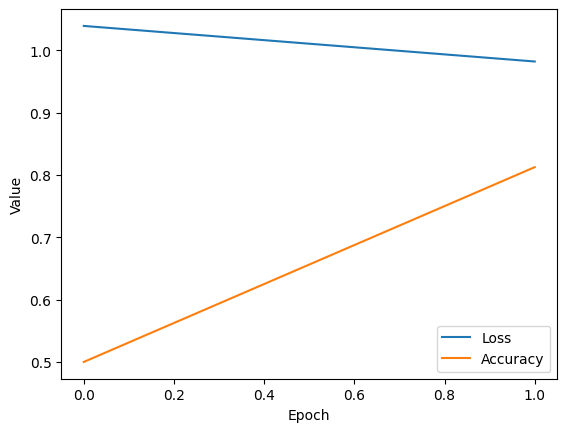

In [24]:
import matplotlib.pyplot as plt

history = {
    'loss': loss_history,
    'accuracy': accuracy_history
}

plt.plot(history['loss'])
plt.plot(history['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(['Loss', 'Accuracy'])
plt.show()

In [26]:
def get_label_with_threshold(text):
    text = str(text)
    encoded_inputs = tokenizer(text, padding=True, truncation=True, return_tensors='pt')

    # Ensure that input tensors are on the same device as the model
    input_ids = encoded_inputs['input_ids'].to(device)
    attention_mask = encoded_inputs['attention_mask'].to(device)

    # Forward pass
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits

    # Convert logits to probabilities and move to CPU for processing
    logits = logits.detach().cpu()
    class_probabilities = torch.softmax(logits, dim=-1).tolist()[0]

    class_names = np.arange(len(class_probabilities))
    class_probabilities_dict = dict(zip(class_names, class_probabilities))

    max_probability = max(class_probabilities_dict.values())
    predicted_class = max(class_probabilities_dict, key=class_probabilities_dict.get)

    return predicted_class, max_probability

In [25]:
# Testing Trained Model

test_df = X_test
test_df['label'] = y_test
test_df = test_df.reset_index(drop=True)
test_df.head()

,text,label
0,fuck yessssssss .,2
1,im getting on borderlands 2 and i will murder ...,2
2,so i spent a few hours doing something for fun...,2
3,that was the first borderlands session in a ho...,2
4,one of our own @ profzeroo is live w / @ borde...,1


In [30]:
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()

In [31]:
test_df['pred'] = test_df.text.progress_apply(lambda x: get_label_with_threshold(x))

  0%|          | 0/20 [00:00<?, ?it/s]

In [33]:
test_df['pred'] = test_df.pred.apply(lambda x: x[0])
test_df.head()

,text,label,pred
0,fuck yessssssss .,2,1
1,im getting on borderlands 2 and i will murder ...,2,1
2,so i spent a few hours doing something for fun...,2,1
3,that was the first borderlands session in a ho...,2,2
4,one of our own @ profzeroo is live w / @ borde...,1,1


In [34]:
total_intents = test_df.shape[0]
matched = test_df[test_df.label == test_df.pred].shape[0]
print('Test Acc:', matched / total_intents * 100)

Test Acc: 40.0


# Save Custom Model

In [ ]:
import pickle

data = {
    'model': model,
    'tokenizer': tokenizer,
    'label encoder': label_encoder
}

# Dump the dictionary to a pickle file
pickle.dump(data, open('bert_base_uncased/custom_bert_model.pkl', 'wb'))